In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("data/combined_stock_data_wide.csv", parse_dates=["Date"])

# Set datetime index
df.set_index("Date", inplace=True)

# Extract closing prices
close_cols = [col for col in df.columns if col.endswith("_Close")]
volume_cols = [col for col in df.columns if col.endswith("_Volume")]

close_df = df[close_cols]
volume_df = df[volume_cols]

Data Cleaning + EDA

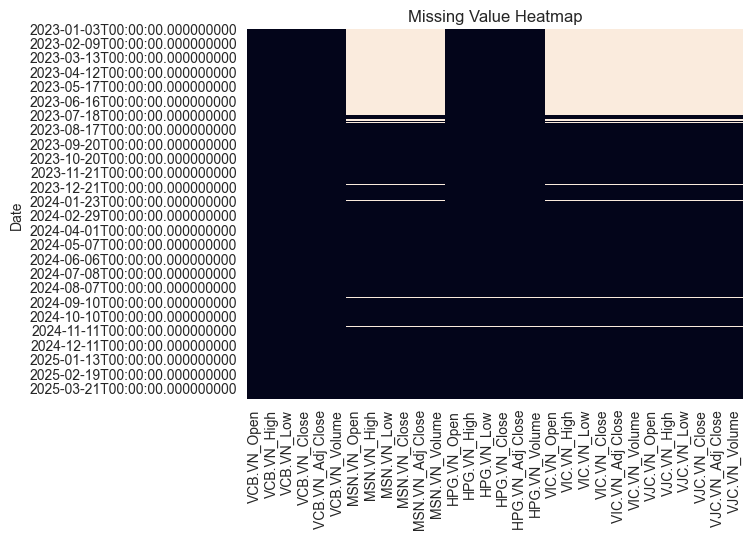

In [3]:
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

In [4]:
df.dropna(inplace=True) #dropping all nulls

Feature Engineering

VCB.VN_Volume    0
MSN.VN_Volume    0
HPG.VN_Volume    0
VIC.VN_Volume    0
VJC.VN_Volume    0
dtype: int64


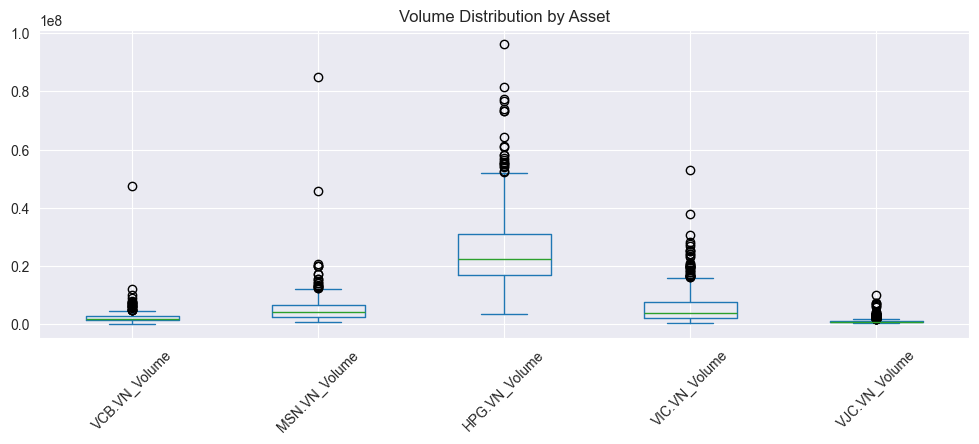

In [5]:
# Count zero or near-zero volumes
print((volume_df == 0).sum().sort_values(ascending=False))

# Boxplot to see volume outliers
volume_df.plot(kind='box', figsize=(12, 4), title="Volume Distribution by Asset")
plt.xticks(rotation=45)
plt.show()

In [6]:
# handling outliers
log_volume = np.log1p(volume_df).diff().dropna()
log_volume.columns = [f"{col}_vol" for col in log_volume.columns]

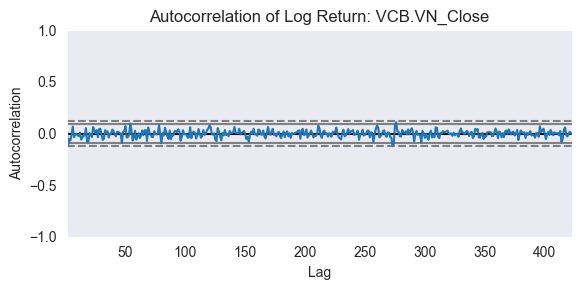

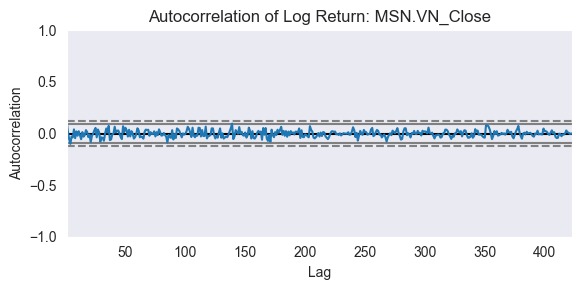

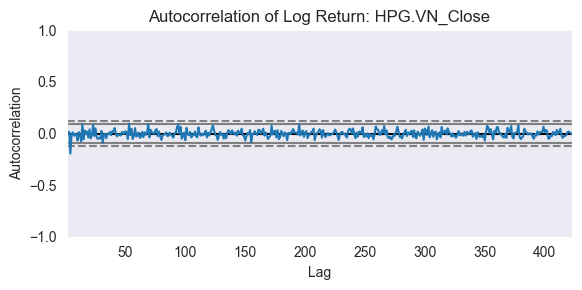

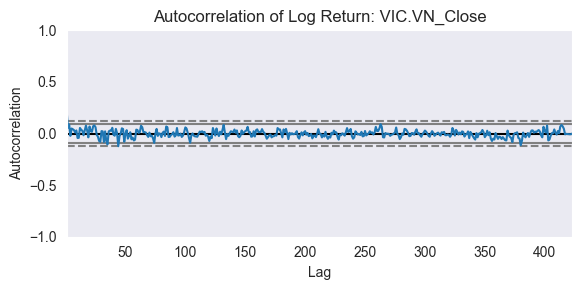

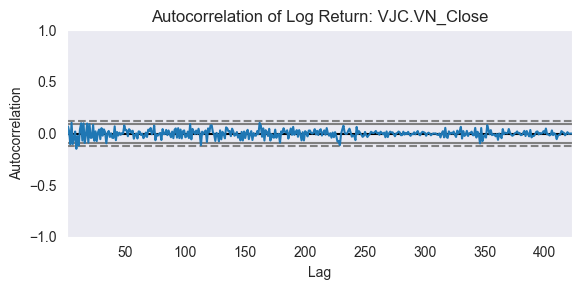

In [7]:
# log returns from close prices
close_cols = [col for col in df.columns if col.endswith('_Close') and 'Adj' not in col]
log_returns = np.log(df[close_cols] / df[close_cols].shift(1)).dropna()

# autocorrelation of log returns
for col in log_returns.columns:
    plt.figure(figsize=(6, 3))
    autocorrelation_plot(log_returns[col])
    plt.title(f'Autocorrelation of Log Return: {col}')
    plt.tight_layout()
    plt.show()

In [8]:
# Rolling window
rolling_windows = [5, 10, 20]

for col in log_returns.columns:
    for w in rolling_windows:
        log_returns[f'{col}_rollmean_{w}'] = log_returns[col].rolling(window=w).mean()
        log_returns[f'{col}_rollstd_{w}'] = log_returns[col].rolling(window=w).std()

Target Construction

In [9]:
features = pd.concat([log_returns, log_volume], axis=1).dropna()
# Concatenating features

In [10]:
# Compute portfolio return (equal weights)
portfolio_return = log_returns.iloc[:, :5].mean(axis=1)

# One-step-ahead realized volatility (absolute return as proxy)
target_volatility = portfolio_return.shift(-1).abs()

# Add to feature set
features['target_volatility'] = target_volatility

# Drop Nulls caused by shifting
features.dropna(inplace=True)

Labeling data

In [13]:
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features.drop(columns=["target_volatility"]))
y = features["target_volatility"].values

Creating learning sequence

In [17]:
def create_sequences(X, y, window=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

X_seq, y_seq = create_sequences(X_scaled, y)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


Defining LSTM

In [21]:
import torch
import torch.nn as nn

class LSTMVolatilityModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(LSTMVolatilityModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Output is 1 scalar: predicted volatility

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # shape: (batch, seq_len, hidden_dim)
        last_hidden = lstm_out[:, -1, :]  # use the output at final time step
        out = self.fc(last_hidden)  # shape: (batch, 1)
        return out

In [22]:
# Hyperparameters
input_dim = X_train.shape[2]
hidden_dim = 64
batch_size = 64
lr = 0.001
epochs = 50

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTMVolatilityModel(input_dim=input_dim, hidden_dim=hidden_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.6f}")


Epoch 1/50 - Train Loss: 0.006123
Epoch 2/50 - Train Loss: 0.002323
Epoch 3/50 - Train Loss: 0.000945
Epoch 4/50 - Train Loss: 0.000768
Epoch 5/50 - Train Loss: 0.000532
Epoch 6/50 - Train Loss: 0.000347
Epoch 7/50 - Train Loss: 0.000281
Epoch 8/50 - Train Loss: 0.000232
Epoch 9/50 - Train Loss: 0.000162
Epoch 10/50 - Train Loss: 0.000143
Epoch 11/50 - Train Loss: 0.000123
Epoch 12/50 - Train Loss: 0.000102
Epoch 13/50 - Train Loss: 0.000088
Epoch 14/50 - Train Loss: 0.000077
Epoch 15/50 - Train Loss: 0.000068
Epoch 16/50 - Train Loss: 0.000062
Epoch 17/50 - Train Loss: 0.000056
Epoch 18/50 - Train Loss: 0.000051
Epoch 19/50 - Train Loss: 0.000047
Epoch 20/50 - Train Loss: 0.000044
Epoch 21/50 - Train Loss: 0.000042
Epoch 22/50 - Train Loss: 0.000039
Epoch 23/50 - Train Loss: 0.000036
Epoch 24/50 - Train Loss: 0.000034
Epoch 25/50 - Train Loss: 0.000033
Epoch 26/50 - Train Loss: 0.000031
Epoch 27/50 - Train Loss: 0.000029
Epoch 28/50 - Train Loss: 0.000027
Epoch 29/50 - Train Loss: 0.0

In [24]:
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze()
    test_loss = loss_fn(preds, y_test)
    print(f"Test Loss (MSE): {test_loss.item():.6f}")


Test Loss (MSE): 0.000464


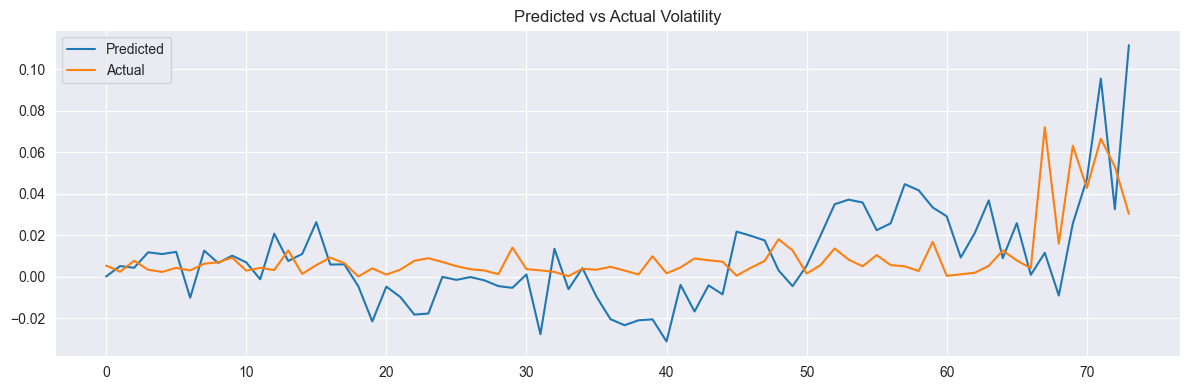

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(preds.numpy(), label='Predicted')
plt.plot(y_test.numpy(), label='Actual')
plt.legend()
plt.title('Predicted vs Actual Volatility')
plt.tight_layout()
plt.show()
